# Imports and configuration

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
from mpl_toolkits.mplot3d import axes3d
from xgboost import XGBClassifier
from datetime import date
from sklearn.metrics import precision_recall_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, confusion_matrix, f1_score, roc_curve, auc, accuracy_score, classification_report, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Will allow us to embed images in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 3)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

r = 666
np.set_printoptions(precision=2)
np.random.seed(r)
# Remember to call np.random.seed(r) before every function that uses np.random

/Users/mattiacrippa/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Loading original dataset

In [2]:
dataset = pd.read_csv('../common/dataset.csv', header=0, index_col='CUST_COD')
target = pd.read_csv('../common/target.csv', header=0, index_col='CUST_COD')
print(dataset.shape)
print(target.shape)

(26884, 24)
(3116, 24)


In [3]:
dataset.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,BIRTH_DATE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,...,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,DEFAULT PAYMENT JAN
CUST_COD,,,,,,,,,,,,,,,,,,,,,
53613503,1490.680,M,university,single,NaN,0,0,0,0,2,...,629.156401,599.283174,608.257067,89.440800,149.06800,68.571280,0.000000,29.81360,59.627200,0
35524089,5664.584,M,university,married,04/01/1983,0,0,0,0,0,...,533.872135,-2.772665,-14.399969,149.068000,159.83071,29.813600,0.000000,0.00000,0.000000,1
58777007,6260.856,F,high school,married,02/01/1975,0,0,-1,-1,-2,...,-19.349026,-19.349026,-19.349026,59.627200,532.59015,16.963938,0.000000,0.00000,29.813600,0
26913418,8944.080,F,graduate school,married,15/01/1977,-2,-2,-2,-2,-2,...,88.546392,70.330282,253.177091,80.556347,217.22189,88.784901,70.628418,298.46395,216.416922,0
41993633,3577.632,F,graduate school,married,09/01/1978,-1,-1,-1,-1,-1,...,0.000000,569.439760,0.000000,119.254400,29.81360,0.000000,569.439760,0.00000,0.000000,1


In [4]:
dataset.describe()

,LIMIT_BAL,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,BILL_AMT_NOV,BILL_AMT_OCT,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,DEFAULT PAYMENT JAN
count,26884.00000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000
mean,4997.91411,-0.016367,-0.133313,-0.166344,-0.219052,-0.264879,-0.291884,1530.136656,1467.012379,1404.166272,1292.346498,1203.977907,1159.529034,168.639427,178.825861,156.416357,144.518815,144.259750,157.534344,0.221098
std,3879.73624,1.123991,1.197715,1.197837,1.171221,1.135089,1.150547,2206.111841,2129.923058,2072.220534,1923.241494,1816.137779,1775.876050,495.392694,688.001298,531.588567,465.903631,463.780141,538.637089,0.414994
min,298.13600,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-4936.535888,-2080.303567,-4688.605990,-2424.859342,-2424.859342,-10124.788000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1490.68000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,105.115300,87.622170,79.535231,68.951403,52.553923,37.594950,29.634718,24.879449,11.627304,8.884453,7.870790,3.637259,0.000000
50%,4173.90400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,667.198554,631.705464,599.491869,568.008707,539.998830,506.920641,62.608560,60.044590,54.260752,44.720400,44.720400,44.720400,0.000000
75%,7155.26400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1997.891324,1905.320095,1798.386166,1629.998953,1504.528417,1473.179417,149.276695,149.068000,134.369895,119.709057,120.379863,119.321481,0.000000
max,29813.60000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,28755.545150,29334.525260,49612.483810,26581.388370,27642.305330,28670.665830,26043.729910,50213.824120,26714.178140,18514.245600,12716.364990,15761.436660,1.000000


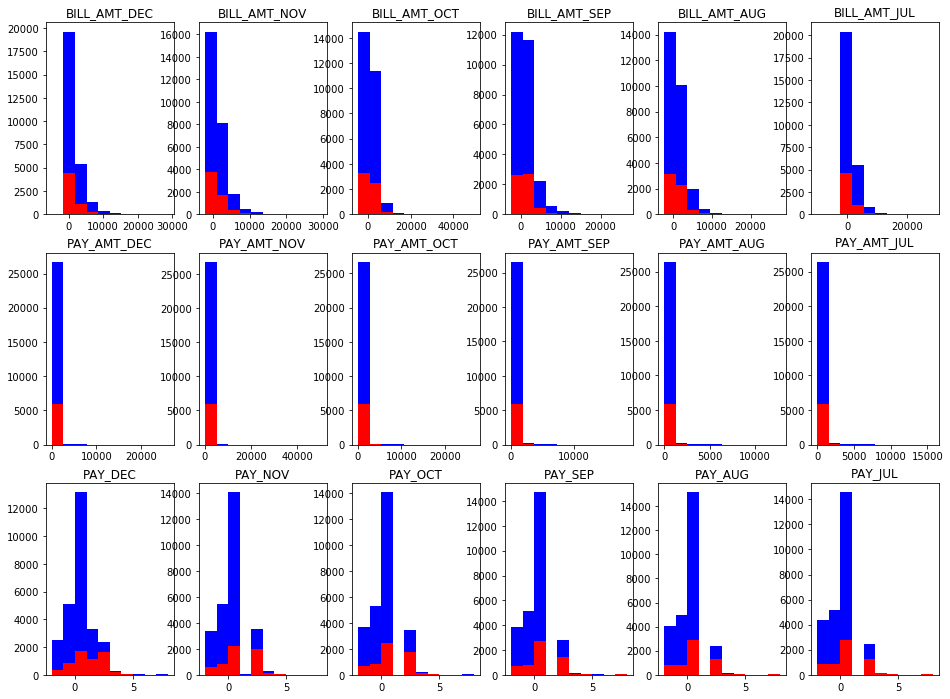

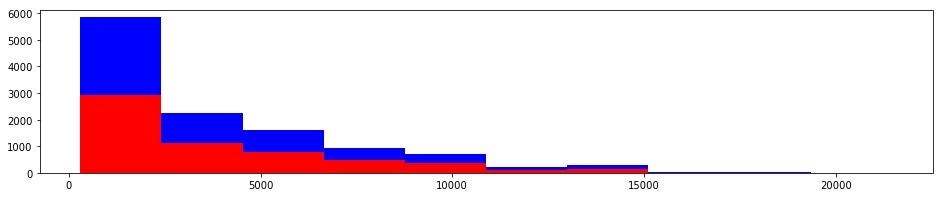

In [5]:
X = dataset

cols = [  'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
              'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL',
             'PAY_DEC', 'PAY_NOV', 'PAY_OCT', 'PAY_SEP', 'PAY_AUG', 'PAY_JUL']
# 13 fields
i = 1

ones_mask = X['DEFAULT PAYMENT JAN'] == 1
zeros_mask = X['DEFAULT PAYMENT JAN'] == 0

fig = plt.figure(figsize=(16, 3 * 4))
for col in cols:
    ax = fig.add_subplot(3,6,i)
    i += 1
    ax.set_title(col)
    ones = X[col][ones_mask]
    zeros = X[col][zeros_mask]
    ax.hist((ones, zeros), histtype='barstacked', bins=10, label=('1', '0'), color=('r', 'b'))
    #ax.legend(loc='best')
plt.show() 

plt.figure()
ones = X['LIMIT_BAL'][ones_mask]
zeros = X['LIMIT_BAL'][ones_mask]
plt.hist((ones,zeros), histtype='barstacked', bins=10, label=('1', '0'), color=('r', 'b'))
#plt.legend(loc='best')
plt.show() 

# Different datasets management
- split_and_add
- add_dataset
- retrieve_dataset

In [6]:
X_dict = {}
y_dict = {}
X_test_dict = {}
y_test_dict = {}
X_target_dict = {}

names = set()
target_col_name = 'DEFAULT PAYMENT JAN'

def split_and_add(name, dataset, target):
    train, test = train_test_split(dataset, test_size=0.33, random_state=r, stratify=dataset[target_col_name])
    X = train.drop([target_col_name], 1)
    y = train[target_col_name]
    X_test = test.drop([target_col_name], 1)
    y_test = test[target_col_name]
    X_target = target.drop(target_col_name, 1)
    add_dataset(name, X, y, X_test, y_test, X_target)
    print('Train X shape: {}'.format(X.shape))
    print('Test X shape: {}'.format(X_test.shape))
    print('Target X shape: {}'.format(X_target.shape))

def add_dataset(name, X, y, X_test, y_test, X_target):
    names.add(name)
    X_dict[name] = X
    y_dict[name] = y
    X_test_dict[name] = X_test
    y_test_dict[name] = y_test
    X_target_dict[name] = X_target

def retrieve_dataset(name):
    return (X_dict[name], y_dict[name], X_test_dict[name], y_test_dict[name], X_target_dict[name])

split_and_add('orig', dataset, target)

non_numerical_features = ['SEX', 'EDUCATION', 'MARRIAGE', 'BIRTH_DATE']
split_and_add('baseline', dataset.drop(non_numerical_features, 1), target.drop(non_numerical_features, 1))

X, y, X_test, y_test, X_target = retrieve_dataset('baseline')
rs = RobustScaler()
rs.fit(X)
X = pd.DataFrame(rs.transform(X), index=X.index, columns=X.columns)
X_test = pd.DataFrame(rs.transform(X_test), index=X_test.index, columns=X_test.columns)
add_dataset('baseline_scaled', X, y, X_test, y_test, X_target)

Train X shape: (18012, 23)
Test X shape: (8872, 23)
Target X shape: (3116, 23)
Train X shape: (18012, 19)
Test X shape: (8872, 19)
Target X shape: (3116, 19)


# Alessandro's dataset
- One hot encoding of SEX
- scores to MARRIAGE and EDUCATION
- BIRTH_DATE transformed to AGE and normalized
- Columns with money values like LIMIT_BAL and BILL_AMT_DEC normalized togheter to mean=0 std=1
- Delay in payments normalized togheter to mean=0 std=1

In [7]:
def transform_features(X_orig):
    X = X_orig.copy()

    # print('One hot encoding SEX feature')
    # set(dataset["SEX"]) = {nan, 'M', 'F'}
    fields = ['SEX']
    for field in fields:
        X = pd.concat([X.drop([field], 1), pd.get_dummies(X[field])], axis=1)

    # print('Scoring EDUCATION and MARRIAGE features')
    # Assume other == Nan
    # set(dataset["EDUCATION"]) = {nan, 'high school', 'graduate school', 'other§', 'university'}
    # set(dataset["MARRIAGE"]) = {nan, 'other', 'single', 'married'}
    education_dict = {'other': 0, 'high school': 0.25, 'university': 0.75, 'graduate school': 1}
    X['EDUCATION'] = X['EDUCATION'].fillna('other').apply(lambda x: education_dict[x])
    marriage_dict = {'other': 0, 'single': 0.5, 'married': 1}
    X['MARRIAGE'] = X['MARRIAGE'].fillna('other').apply(lambda x: marriage_dict[x])

    #print('Computing AGE and dropping BIRTH_DATE')
    # Target: Year-Month-DayTTime
    X['BIRTH_DATE'] = pd.to_datetime(X['BIRTH_DATE'])
    def calculate_age(birth_date):
        today = date.today()
        age = today.year - birth_date.year
        full_year_passed = (today.month, today.day) < (birth_date.month, birth_date.day)
        if not full_year_passed:
            age -= 1
        return age
    X['AGE'] = X['BIRTH_DATE'].apply(lambda x: calculate_age(x))
    X = X.drop(["BIRTH_DATE"], 1)
    X['AGE'] = X['AGE'].fillna(X['AGE'].median())
    
    fields = ['LIMIT_BAL',
              'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
              'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL']

    # print('Normalizing € fields')
    X[fields] = X[fields].apply(lambda x: np.cbrt(x))
    # np.cbrt is the only one that works with negative numbers
    # using pow with 1/3 or 1/5 etc with negative numbers leads to complex number as results because of
    # numerical approximations
    # np.cbrt instead apply the direct algorithm to find cubic root, which is well defined for every negative numbe
    
    # print('Dataset prepared')
    # print(X.shape)
    
    return X.copy()

X, y, X_test, y_test, X_target = retrieve_dataset(name='orig')
add_dataset('ale', transform_features(X), y, transform_features(X_test), y_test, transform_features(X_target))
X, y, X_test, y_test, X_target = retrieve_dataset(name='ale')
X.head(5)

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,F,M,AGE
CUST_COD,,,,,,,,,,,,,,,,,,,,,
14356766,13.360872,0.75,0.5,1,2,2,2,2,-2,4.951950,...,0.000000,0.000000,5.119281,0.855483,0.000000,0.000000,0.000000,1,0,28.0
21308338,8.416822,1.00,0.5,0,0,0,0,0,0,7.777672,...,8.427890,5.302266,3.906743,3.549511,3.100784,2.615302,3.100784,1,0,23.0
54049646,17.507695,0.25,1.0,0,0,0,0,0,0,14.005143,...,13.631800,4.877483,5.302972,4.546873,5.302266,4.490414,4.569354,1,0,49.0
10396398,9.634856,0.25,0.5,-1,-1,-2,-2,-2,-2,2.706525,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,50.0
11528589,14.857157,0.75,1.0,0,0,0,0,0,0,11.382419,...,10.220138,4.475580,4.472104,4.472104,4.472104,4.922187,4.472104,0,1,40.0


In [8]:
X.describe().round(3)

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,F,M,AGE
count,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,...,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000
mean,15.837,0.745,0.719,-0.009,-0.129,-0.162,-0.211,-0.256,-0.285,8.935,...,7.692,4.042,4.000,3.738,3.561,3.532,3.524,0.595,0.396,35.608
std,4.610,0.268,0.260,1.122,1.191,1.195,1.176,1.143,1.158,5.485,...,5.456,2.693,2.769,2.733,2.729,2.706,2.868,0.491,0.489,9.081
min,6.680,0.000,0.000,-2.000,-2.000,-2.000,-2.000,-2.000,-2.000,-17.027,...,-21.634,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,21.000
25%,11.423,0.750,0.500,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,4.830,...,3.341,3.101,2.913,2.265,2.042,1.956,1.489,0.000,0.000,28.000
50%,16.101,0.750,0.500,0.000,0.000,0.000,0.000,0.000,0.000,8.856,...,8.017,3.971,3.916,3.791,3.550,3.550,3.550,1.000,0.000,34.000
75%,19.270,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,12.646,...,11.391,5.304,5.302,5.119,4.925,4.930,4.922,1.000,1.000,41.000
max,28.172,1.000,1.000,8.000,7.000,8.000,7.000,7.000,8.000,28.133,...,25.057,24.693,33.197,24.745,23.443,23.184,25.073,1.000,1.000,75.000


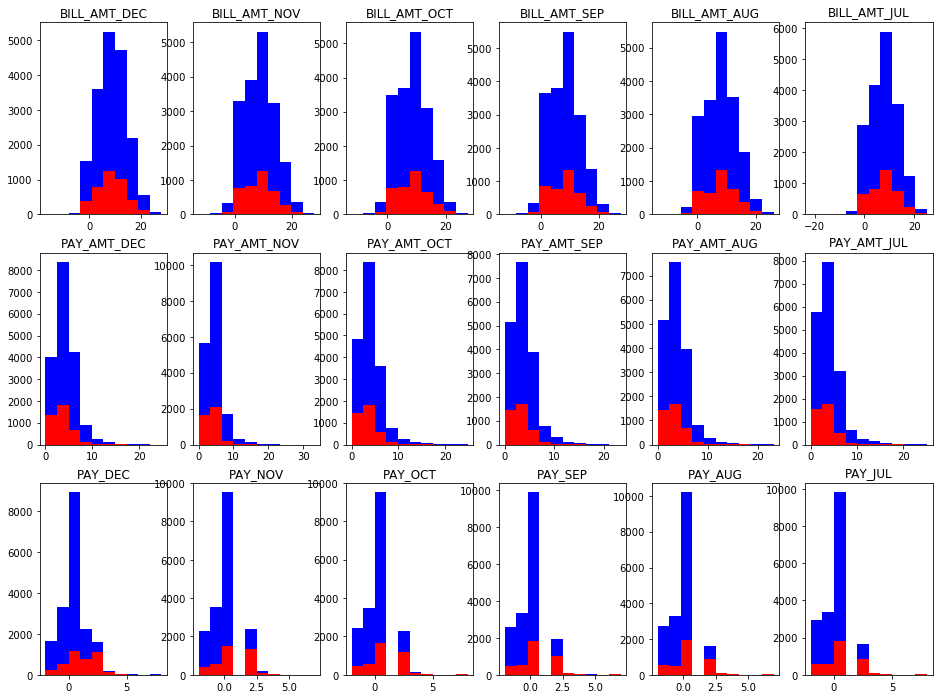

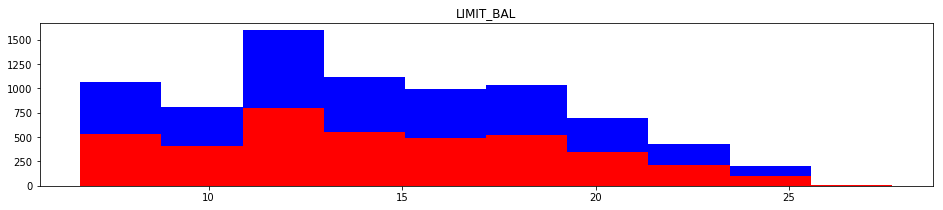

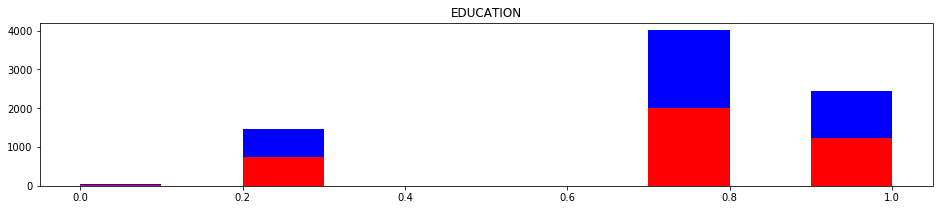

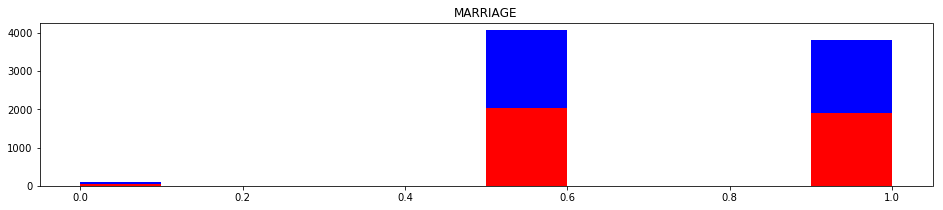

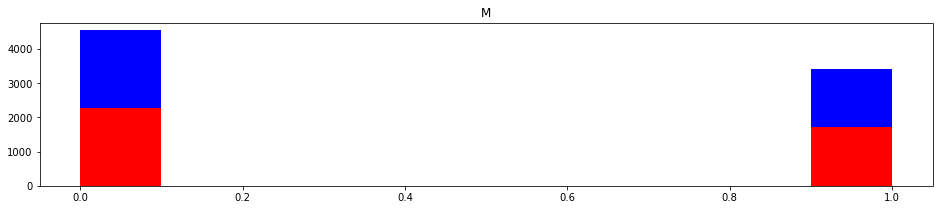

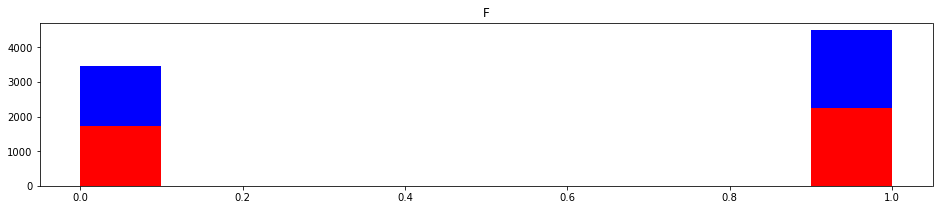

In [9]:
X, y, _, _, _ = retrieve_dataset(name='ale')

cols = [  'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
              'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL',
             'PAY_DEC', 'PAY_NOV', 'PAY_OCT', 'PAY_SEP', 'PAY_AUG', 'PAY_JUL']
# 13 fields
i = 1

ones_mask = y == 1
zeros_mask = y == 0

fig = plt.figure(figsize=(16, 3 * 4))
for col in cols:
    ax = fig.add_subplot(3,6,i)
    i += 1
    ax.set_title(col)
    ones = X[col][ones_mask]
    zeros = X[col][zeros_mask]
    ax.hist((ones, zeros), histtype='barstacked', bins=10, label=('1', '0'), color=('r', 'b'))
plt.show() 

plt.figure()
ones = X['LIMIT_BAL'][ones_mask]
zeros = X['LIMIT_BAL'][ones_mask]
plt.title('LIMIT_BAL')
plt.hist((ones,zeros), histtype='barstacked', bins=10, label=('1', '0'), color=('r', 'b'))
plt.show()

plt.figure()
ones = X['EDUCATION'][ones_mask]
zeros = X['EDUCATION'][ones_mask]
plt.title('EDUCATION')
plt.hist((ones,zeros), histtype='barstacked', bins=10, label=('1', '0'), color=('r', 'b'))
plt.show()

plt.figure()
ones = X['MARRIAGE'][ones_mask]
zeros = X['MARRIAGE'][ones_mask]
plt.title('MARRIAGE')
plt.hist((ones,zeros), histtype='barstacked', bins=10, label=('1', '0'), color=('r', 'b'))
plt.show()

plt.figure()
ones = X['M'][ones_mask]
zeros = X['M'][ones_mask]
plt.title('M')
plt.hist((ones,zeros), histtype='barstacked', bins=10, label=('1', '0'), color=('r', 'b'))
plt.show()

plt.figure()
ones = X['F'][ones_mask]
zeros = X['F'][ones_mask]
plt.title('F')
plt.hist((ones,zeros), histtype='barstacked', bins=10, label=('1', '0'), color=('r', 'b'))
plt.show()

# Dataset Creation - ale_scaled

In [10]:
X, y, X_test, y_test, X_target = retrieve_dataset('ale')
rs = RobustScaler()
rs.fit(X)
X_scaled = pd.DataFrame(rs.transform(X), columns=X.columns, index=X.index)
X_test_scaled = pd.DataFrame(rs.transform(X_test), columns=X_test.columns, index=X_test.index)
X_target_scaled = pd.DataFrame(rs.transform(X_target), columns=X_target.columns, index=X_target.index)
add_dataset('ale_scaled', X_scaled, y, X_test_scaled, y_test, X_target_scaled)
X_scaled.head(5)

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,F,M,AGE
CUST_COD,,,,,,,,,,,,,,,,,,,,,
14356766,-0.349199,0.0,0.0,1.0,2.0,2.0,2.0,2.0,-2.0,-0.499532,...,-0.995851,-1.802536,0.503453,-1.028644,-1.231275,-1.193516,-1.033907,0.0,0.0,-0.461538
21308338,-0.979309,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.137981,...,0.051072,0.604417,-0.004078,-0.084631,-0.155657,-0.314126,-0.130706,0.0,0.0,-0.846154
54049646,0.179306,-2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.658823,...,0.697508,0.411587,0.580341,0.264854,0.608005,0.316377,0.297061,0.0,0.0,1.153846
10396398,-0.824073,-2.0,0.0,-1.0,-1.0,-2.0,-2.0,-2.0,-2.0,-0.786834,...,-0.995851,-1.802536,-1.639320,-1.328413,-1.231275,-1.193516,-1.033907,0.0,0.0,1.230769
11528589,-0.158500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.323245,...,0.273707,0.229144,0.232565,0.238655,0.320034,0.461559,0.268734,-1.0,1.0,0.461538


In [11]:
if False:
    X, y, X_test, y_test, _ = retrieve_dataset('ale_scaled')
    pd.concat([X, y], axis=1).to_csv('train.csv', index=False)
    pd.concat([X_test, y_test], axis=1).to_csv('test.csv', index=False)

In [12]:
X_scaled.describe().round(3)

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,F,M,AGE
count,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,...,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000
mean,-0.034,-0.022,0.438,-0.009,-0.129,-0.162,-0.211,-0.256,-0.285,0.010,...,-0.040,0.032,0.035,-0.018,0.004,-0.006,-0.007,-0.405,0.396,0.124
std,0.588,1.072,0.521,1.122,1.191,1.195,1.176,1.143,1.158,0.702,...,0.678,1.223,1.159,0.958,0.947,0.910,0.835,0.491,0.489,0.699
min,-1.201,-3.000,-1.000,-2.000,-2.000,-2.000,-2.000,-2.000,-2.000,-3.312,...,-3.683,-1.803,-1.639,-1.328,-1.231,-1.194,-1.034,-1.000,0.000,-1.000
25%,-0.596,0.000,0.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-0.515,...,-0.581,-0.395,-0.420,-0.535,-0.523,-0.536,-0.600,-1.000,0.000,-0.462
50%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.404,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.485,...,0.419,0.605,0.580,0.465,0.477,0.464,0.400,0.000,1.000,0.538
max,1.539,1.000,1.000,8.000,7.000,8.000,7.000,7.000,8.000,2.466,...,2.117,9.407,12.256,7.343,6.901,6.602,6.269,0.000,1.000,3.154


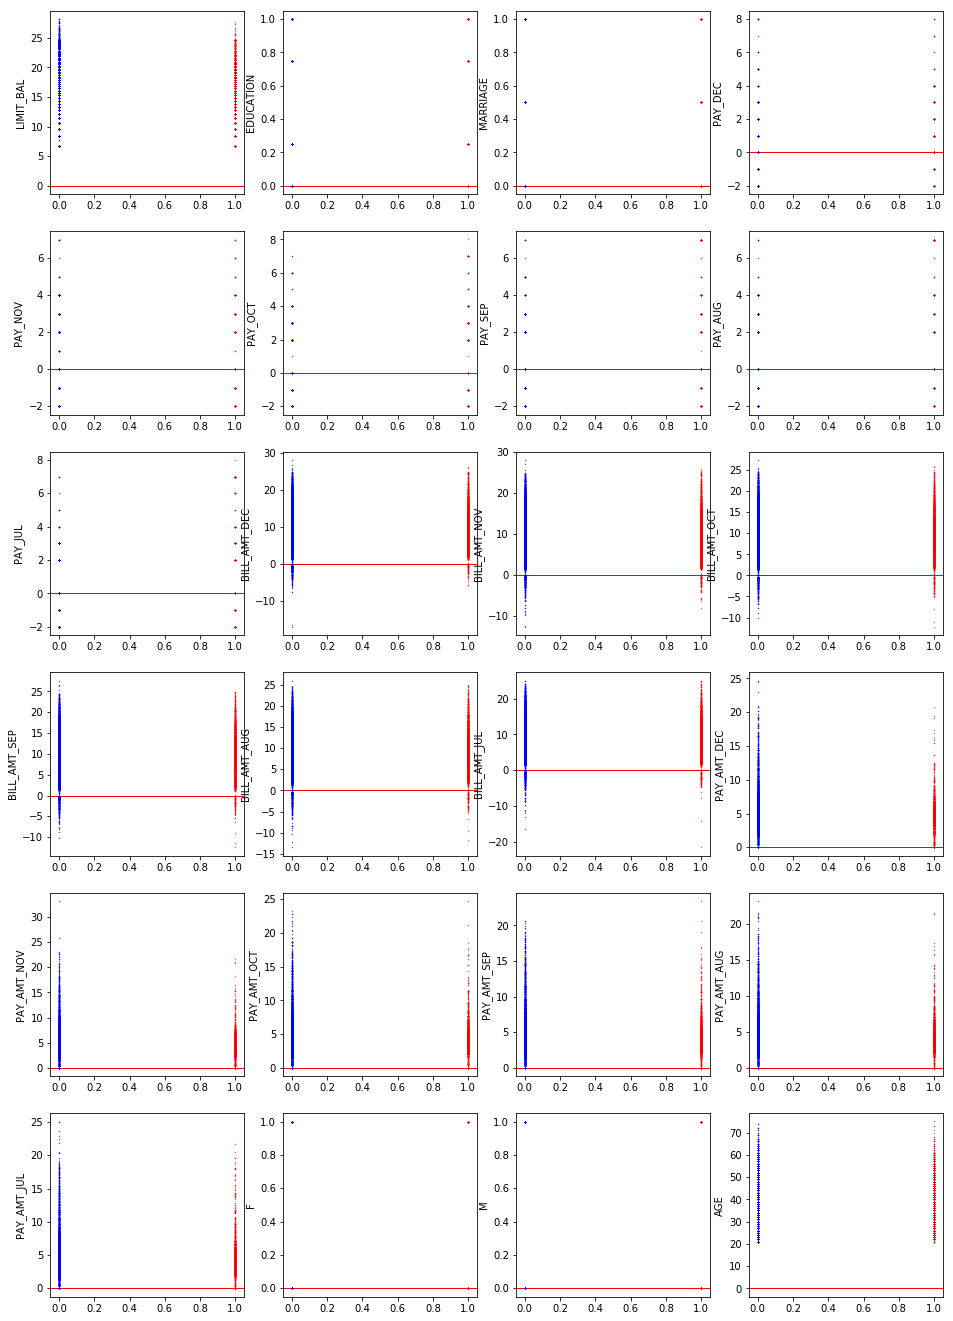

In [13]:
X, y, _, _, _ = retrieve_dataset('ale')
i = 1
fig = plt.figure(figsize=(16, 12 * 4))
for col_name in X.columns:
    ax = fig.add_subplot(12, 4, i)
    i += 1
    ax.set_ylabel(col_name)
    ax.scatter(y[y==1], X[col_name][y == 1], c='r', s=0.1)
    ax.scatter(y[y==0], X[col_name][y == 0], c='b', s=0.1)
    ax.axhline(y=0, c='red', linewidth=1, zorder=0)
plt.show()

# Plot confusion matrix function

In [14]:
classes = ['0', '1']

def plot_confusion_matrix(cm, classes=classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    #if normalize:
    #    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


# Preliminary Prediction Tests

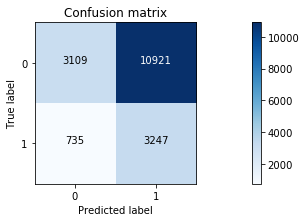

             precision    recall  f1-score   support

          0       0.81      0.22      0.35     14030
          1       0.23      0.82      0.36      3982

avg / total       0.68      0.35      0.35     18012



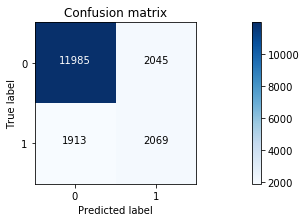

             precision    recall  f1-score   support

          0       0.86      0.85      0.86     14030
          1       0.50      0.52      0.51      3982

avg / total       0.78      0.78      0.78     18012



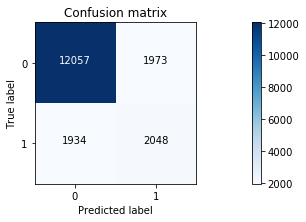

             precision    recall  f1-score   support

          0       0.86      0.86      0.86     14030
          1       0.51      0.51      0.51      3982

avg / total       0.78      0.78      0.78     18012



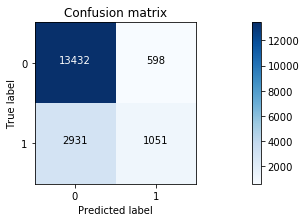

             precision    recall  f1-score   support

          0       0.82      0.96      0.88     14030
          1       0.64      0.26      0.37      3982

avg / total       0.78      0.80      0.77     18012



In [15]:
X, y, _, _, _ = retrieve_dataset(name='orig')

y_pred = X['PAY_AMT_DEC'] < X['BILL_AMT_DEC']
plot_confusion_matrix(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

y_pred = (X['PAY_DEC'] > 0)
plot_confusion_matrix(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

y_pred = (X['PAY_DEC'] > 0)
y_pred &= (X['PAY_AMT_DEC'] < X['BILL_AMT_DEC'] + 1000)
y_pred &= (X['PAY_AMT_NOV'] < X['BILL_AMT_NOV'] + 1000)
y_pred &= (X['PAY_AMT_OCT'] < X['BILL_AMT_OCT'] + 1000)
plot_confusion_matrix(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

y_pred = (X['PAY_DEC'] > 0)
y_pred &= (X['PAY_NOV'] > 0)
y_pred &= (X['PAY_OCT'] > 0)
plot_confusion_matrix(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

# PAY_AMT vs Month, BILL_AMT vs Month

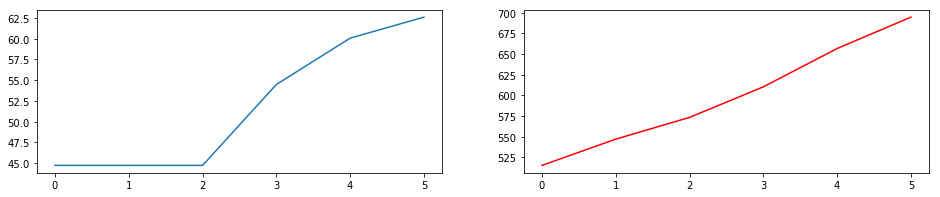

In [16]:
X, y, _, _, _ = retrieve_dataset(name='orig')
months = ['JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

m = [X['PAY_AMT_{}'.format(month)].median() for month in months]

fig = plt.figure(figsize=(16, 3))
ax = fig.add_subplot(1, 2, 1)
ax.plot(m)
m = [X['BILL_AMT_{}'.format(month)].median() for month in months]
ax = fig.add_subplot(1, 2, 2)
ax.plot(m, c='r')

plt.show()

# 2D PCA - ale_scaled

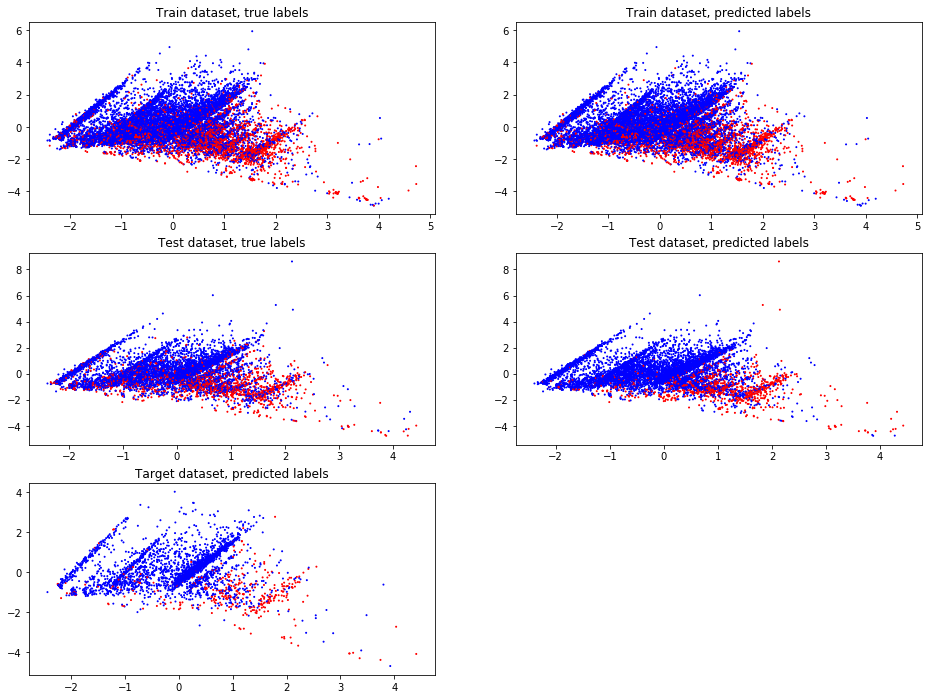

In [17]:
X, y, X_test, y_test, X_target = retrieve_dataset('ale_scaled')

colors = {0: 'b', 1: 'r'}
sizes = {0: 1, 1: 1}

def color(y):
    return pd.Series(y).apply(lambda x: colors[x])
def size(y):
    return pd.Series(y).apply(lambda x: sizes[x])

pca = PCA(whiten=True, random_state=r, n_components=2)
pca.fit(X)

X_tf = pd.DataFrame(pca.transform(X), index=X.index)

# clf = XGBClassifier(scale_pos_weight=3)
clf = RandomForestClassifier()
clf.fit(X_tf, y)

y_pred = clf.predict(X_tf)

X_test_tf = pd.DataFrame(pca.transform(X_test), index=X_test.index)
y_test_pred = clf.predict(X_test_tf)

X_target_tf = pd.DataFrame(pca.transform(X_target), index=X_target.index)
y_target_pred = clf.predict(X_target_tf)

fig = plt.figure(figsize=(16, 3 * 4))

ax = fig.add_subplot(3, 2, 1)
ax.set_title('Train dataset, true labels')
ax.scatter(X_tf[0], X_tf[1], c=color(y), s=size(y))

ax = fig.add_subplot(3, 2, 2)
ax.set_title('Train dataset, predicted labels')
ax.scatter(X_tf[0], X_tf[1], c=color(y_pred), s=size(y_pred))

ax = fig.add_subplot(3, 2, 3)
ax.set_title('Test dataset, true labels')
ax.scatter(X_test_tf[0], X_test_tf[1], c=color(y_test), s=size(y_test))

ax = fig.add_subplot(3, 2, 4)
ax.set_title('Test dataset, predicted labels')
ax.scatter(X_test_tf[0], X_test_tf[1], c=color(y_test_pred), s=size(y_test_pred))

# No true labels on target dataset

ax = fig.add_subplot(3, 2, 5)
ax.set_title('Target dataset, predicted labels')
ax.scatter(X_target_tf[0], X_target_tf[1], c=color(y_target_pred), s=size(y_target_pred))

plt.show()

# 3D PCA - ale_scaled

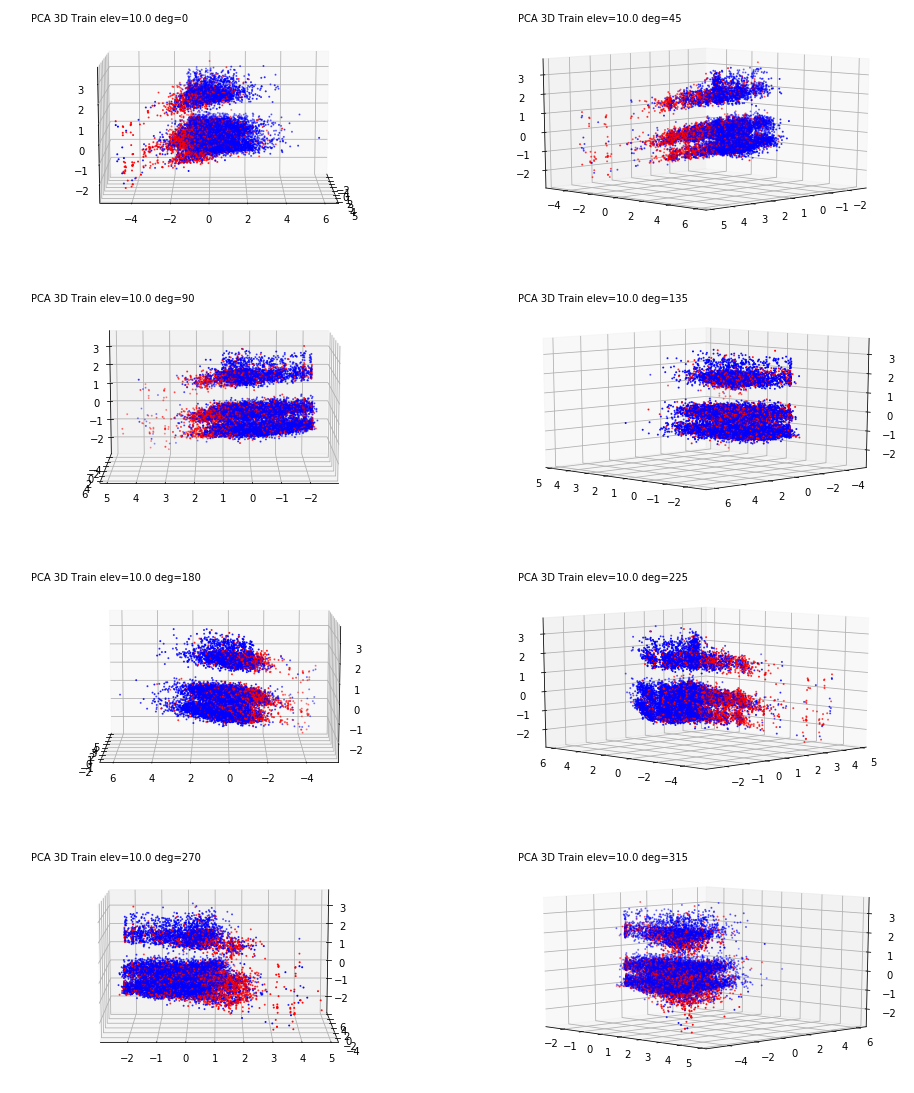

In [18]:
X, y, _, _, _ = retrieve_dataset('ale_scaled')

colors = {0: 'b', 1: 'r', 2: 'y'}
sizes = {0: 1, 1: 1}
c = y.apply(lambda x: colors[x])
s = y.apply(lambda x: sizes[x])

pca = PCA(whiten=True, random_state=r, n_components=3)
pca.fit(X)
df = pd.DataFrame(pca.transform(X), index=X.index)
# kmeans = KMeans(n_clusters=5, random_state=r, copy_x=True, n_jobs=-1).fit(df)
# c = list(map(lambda x: 'C{}'.format(x), list(kmeans.predict(df))))
fig = plt.figure(figsize=(16, 6 * 5))
for ii in np.arange(0, 360, 45):
    ax = fig.add_subplot(6, 2, ii / 45 + 1, projection='3d')
    ax.text2D(0.05, 0.95, 'PCA 3D Train elev={} deg={}'.format(10., ii), transform=ax.transAxes)
    ax.view_init(elev=10., azim=ii)
    ax.scatter(df[0], df[1], df[2], c=c, s=s)
plt.show()

# PCA - tresh = 0.95

Starting PCA
cumsum_tresh = 0.8, n_components = 7
cumsum_tresh = 0.85, n_components = 9
cumsum_tresh = 0.9, n_components = 11
cumsum_tresh = 0.95, n_components = 13
cumsum_tresh = 0.97, n_components = 15
cumsum_tresh = 0.99, n_components = 18


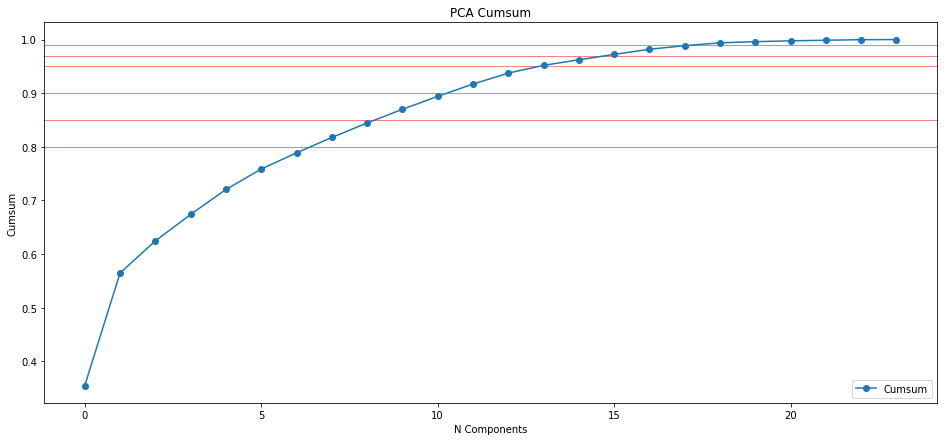

Selecting tresh = 0.95 -> n_components = 13


In [19]:
X, y, X_test, y_test, X_target = retrieve_dataset('ale_scaled')

print('Starting PCA')
pca = PCA(whiten=True, random_state=r)
pca.fit(X)

cumsum = sorted(list(pca.explained_variance_ratio_.cumsum()))

def find_cumsum_tresh(cumsum, cumsum_tresh):
    for i in np.arange(0, len(cumsum)):
        if cumsum[i] >= cumsum_tresh:
            break
    return i

plt.figure(figsize=(16, 7))
plt.plot(cumsum, label='Cumsum', marker='o')
plt.xlabel('N Components')
plt.ylabel('Cumsum')
plt.title('PCA Cumsum')
plt.legend(loc='best')

for i in [0.8, 0.85, 0.9, 0.95, 0.97, 0.99]:
    n_components = find_cumsum_tresh(cumsum, i)
    print('cumsum_tresh = {}, n_components = {}'.format(i, n_components))
    plt.axhline(y=i, c='red', linewidth=0.5, zorder=0)

plt.show()

tresh = 0.95

n_components = find_cumsum_tresh(cumsum, tresh)
print('Selecting tresh = {} -> n_components = {}'.format(tresh, n_components))
pca = PCA(whiten=True, random_state=r, n_components=n_components)
pca.fit(X)

X_pca = pd.DataFrame(pca.transform(X), index=X.index)
X_pca_test = pd.DataFrame(pca.transform(X_test), index=X_test.index)
X_pca_target = pd.DataFrame(pca.transform(X_target), index=X_target.index)

add_dataset('ale_pca', X_pca, y, X_pca_test, y_test, X_pca_target)

In [20]:
X, y, _, _, _ = retrieve_dataset('ale_pca')
X.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12
CUST_COD,,,,,,,,,,,,,
14356766,0.539560,-2.000087,-0.380932,0.064483,-0.394688,2.766635,-0.248070,1.782874,-1.314807,-0.520083,1.336411,-1.506431,-0.765300
21308338,0.142731,-0.115160,-1.089712,0.679291,0.330069,0.219210,0.321141,-0.622524,-1.305355,-0.103554,-0.002952,-0.088675,-0.141140
54049646,0.576763,0.568492,2.036920,-0.369656,-0.275537,-0.289492,-0.193179,-0.239347,0.522757,-0.608228,-0.867688,-0.787530,-0.198540
10396398,-1.932924,-1.037056,2.099321,-0.503085,-0.145283,-0.146750,0.146194,-0.251873,-0.041706,-0.938510,-0.365385,-0.283058,-0.065064
11528589,0.331127,0.266395,0.106188,-0.120938,-0.083714,-0.238710,-0.180023,0.390986,1.012542,0.085010,0.305832,0.728619,0.157295


In [21]:
X.describe().round(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000
mean,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-2.436,-4.873,-2.509,-5.027,-5.838,-6.138,-5.424,-5.566,-3.511,-4.159,-4.533,-4.152,-5.950
25%,-0.683,-0.631,-0.783,-0.497,-0.437,-0.427,-0.411,-0.505,-0.721,-0.713,-0.638,-0.702,-0.483
50%,0.193,-0.061,-0.156,0.010,-0.022,-0.025,0.081,-0.077,-0.069,-0.176,-0.029,-0.069,-0.009
75%,0.630,0.600,0.225,0.481,0.375,0.420,0.468,0.477,0.642,0.614,0.603,0.739,0.438
max,4.732,5.914,3.400,5.735,6.247,8.055,5.955,7.214,4.405,6.049,5.290,4.415,8.310


In [22]:
X, y, X_test, y_test, X_target = retrieve_dataset('ale_scaled')
kmeans = KMeans(random_state=r, n_clusters=4, n_jobs=-1)
kmeans.fit(X)
X = pd.concat([X, pd.get_dummies(pd.Series(kmeans.predict(X), index=X.index), prefix='CLUSTER')], axis=1)
X_test = pd.concat([X_test, pd.get_dummies(pd.Series(kmeans.predict(X_test), index=X_test.index), prefix='CLUSTER')], axis=1)
X_target = pd.concat([X_target, pd.get_dummies(pd.Series(kmeans.predict(X_target), index=X_target.index), prefix='CLUSTER')], axis=1)
add_dataset('ale_kmeans', X, y, X_test, y_test, X_target)
X.head(5)

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,F,M,AGE,CLUSTER_0,CLUSTER_1,CLUSTER_2,CLUSTER_3
CUST_COD,,,,,,,,,,,,,,,,,,,,,
14356766,-0.349199,0.0,0.0,1.0,2.0,2.0,2.0,2.0,-2.0,-0.499532,...,-1.231275,-1.193516,-1.033907,0.0,0.0,-0.461538,0,0,0,1
21308338,-0.979309,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.137981,...,-0.155657,-0.314126,-0.130706,0.0,0.0,-0.846154,0,1,0,0
54049646,0.179306,-2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.658823,...,0.608005,0.316377,0.297061,0.0,0.0,1.153846,1,0,0,0
10396398,-0.824073,-2.0,0.0,-1.0,-1.0,-2.0,-2.0,-2.0,-2.0,-0.786834,...,-1.231275,-1.193516,-1.033907,0.0,0.0,1.230769,0,0,1,0
11528589,-0.158500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.323245,...,0.320034,0.461559,0.268734,-1.0,1.0,0.461538,0,1,0,0


# CV and scoring functions

In [23]:
cv = StratifiedKFold(n_splits=10, random_state=r, shuffle=True)

# DISABLED - Undersample and Oversample

In [24]:
if False:
    X, y, X_test, y_test, X_target = retrieve_dataset('ale_scaled')
    i = 0
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    #clf = MLPClassifier(hidden_layer_sizes=(9,7), validation_fraction=0.1, random_state=r)
    #clf = XGBClassifier(seed=r)
    clf = RandomForestClassifier(random_state=r, n_jobs=-1, n_estimators=300, max_depth=3, max_features=4)
    # clf = LogisticRegression(penalty='l2', C=10, fit_intercept=True, random_state=r, n_jobs=-1)
    # clf = ExtraTreesClassifier(n_estimators=100)
    f1s = []
    np.random.seed(r)
    def under_sample(y, train):
        y_train_fold = y[train]
        n = y_train_fold.count()
        n_ones = y_train_fold.sum()
        n_zeros = n - n_ones
        train_ones = train[y_train_fold == 1]
        train_zeros = train[y_train_fold == 0]
        train_zeros = np.setdiff1d(train_zeros, np.random.choice(train_zeros, n_zeros - n_ones, replace=False))
        return np.append(train_ones, train_zeros)

    #from imblearn.over_sampling import SMOTE
    #sm = SMOTE(random_state=r, kind='svm', n_jobs=-1)

    for train, test in cv.split(X, y):
        train = under_sample(y, train)
        clf.fit(X.iloc[train], y.iloc[train])

        #X_fold_train = X.iloc[train]
        #y_fold_train = y.iloc[train]
        #X_res, y_res = sm.fit_sample(X_fold_train, y_fold_train)
        #X_res = pd.DataFrame(X_res, columns=X.columns)

        y_pred = clf.predict(X.iloc[test])
        f1 = f1_score(y[test], y_pred)
        f1s.append(f1)
        print('fold {}, f1 {}, accuracy {}'.format(i, f1, accuracy_score(y[test], y_pred)))
        i += 1

    print('f1 {} +- {}'.format(np.mean(f1s), np.std(f1s)))

# Cross validate and score

In [25]:
def cv_clf(clf, tresholds, X, y):
    probas = []
    trues = []
    i = 1
    for train, test in cv.split(X, y):
        print('Fold {}/10'.format(i))
        i += 1
        clf.fit(X.iloc[train], y.iloc[train])
        probas.append(clf.predict_proba(X.iloc[test])[:,1])
        trues.append(y.iloc[test])
    
    if (len(tresholds) == 1):
        best_t = tresholds[0]
    else:
        best_t = -1
        best_f1 = -1
        for t in sorted(tresholds):
            f1s = []
            accs = []
            precs = []
            recs = []
            for i in np.arange(len(probas)):
                y_true = trues[i]
                y_pred = pd.Series(probas[i]).apply(lambda x: 1 if x >= t else 0)

                f1s.append(f1_score(y_true, y_pred))
                accs.append(accuracy_score(y_true, y_pred))
                precs.append(precision_score(y_true, y_pred))
                recs.append(recall_score(y_true, y_pred))
            curr_f1 = np.mean(f1s)
            if (curr_f1 > best_f1):
                best_f1 = curr_f1
                best_t = t
                if False:
                    print('New best t = {}!'.format(t))
                    print('f1_cv = {:.3f} ± {:.3f}'.format(np.mean(f1s), np.std(f1s)))
                    print('acc_cv = {:.3f} ± {:.3f}'.format(np.mean(accs), np.std(accs)))
                    print('prec_cv = {:.3f} ± {:.3f}'.format(np.mean(precs), np.std(precs)))
                    print('rec_cv = {:.3f} ± {:.3f}'.format(np.mean(recs), np.std(recs)))    
        
    f1s = []
    accs = []
    precs = []
    recs = []
    for i in np.arange(len(probas)):
        y_true = trues[i]
        y_pred = pd.Series(probas[i]).apply(lambda x: 1 if x >= best_t else 0)

        f1s.append(f1_score(y_true, y_pred))
        accs.append(accuracy_score(y_true, y_pred))
        precs.append(precision_score(y_true, y_pred))
        recs.append(recall_score(y_true, y_pred))
    print('==== Cross validation report ====')
    print('Threshold = {}'.format(best_t))
    print('f1_cv = {:.3f} ± {:.3f}'.format(np.mean(f1s), np.std(f1s)))
    print('acc_cv = {:.3f} ± {:.3f}'.format(np.mean(accs), np.std(accs)))
    print('prec_cv = {:.3f} ± {:.3f}'.format(np.mean(precs), np.std(precs)))
    print('rec_cv = {:.3f} ± {:.3f}'.format(np.mean(recs), np.std(recs)))
    print('==================================')
    return best_t

def train_cv_test_score_target_pred(clf, name, tresholds=np.arange(0, 1, 0.01)):
    print('Evaluating on ' + name + ' dataset')
    X, y, X_test, y_test, X_target = retrieve_dataset(name)
    
    # Cross validate on X, y and determine best treshold
    t_best = cv_clf(clf, tresholds, X, y)
    
    # Use best threshold on cv to predict on test
    clf.fit(X, y)
    y_pred_test = pd.Series(clf.predict_proba(X_test)[:,1], index=X_test.index).apply(lambda x: 1 if x>=t_best else 0)
    
    print('======= Test report =============')
    print('Threshold = {}'.format(t_best))
    plot_confusion_matrix(confusion_matrix(y_test, y_pred_test))
    print('f1 = {:.3f}'.format(f1_score(y_test, y_pred_test)))
    print('acc = {:.3f}'.format(accuracy_score(y_test, y_pred_test)))
    print('prec = {:.3f}'.format(precision_score(y_test, y_pred_test)))
    print('rec = {:.3f}'.format(recall_score(y_test, y_pred_test))) 
    print('==================================')
    
    # Generate predictions for target
    y_pred_target = pd.Series(clf.predict_proba(X_target)[:,1], index=X_target.index).apply(lambda x: 1 if x>=t_best else 0)
    
    return y_pred_target

# ROC curve function

In [26]:
def plot_roc_curve(clf, tresh, X_test, y_test):
    y_pred_proba = clf.predict_proba(X_test)[:,1]
    # Compute ROC curve and ROC area for each class
    fpr, tpr, t = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    i = sum(tt <= tresh for tt in t)
    
    plt.figure(figsize=(16,7))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.plot(fpr[i], tpr[i], 'ro')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Grid Search CV function

In [27]:
def grid_search_cv(parameters, clf, dataset_name='baseline', scoring='f1'):
    n_jobs = -1
    if scoring == ms:
        n_jobs = 1
    gscv = GridSearchCV(estimator=clf, param_grid=parameters, n_jobs=n_jobs, cv=cv, scoring=scoring)
    X, y, X_test, y_test, _ = retrieve_dataset(dataset_name)
    gscv.fit(X, y)
    print('GridSearchCV done on: ' + dataset_name)
    print(gscv.best_params_)
    if scoring == ms:
            scoring = 'score'
    print(scoring + ' = ' + str(gscv.best_score_))
    if len(parameters) == 1:
        plt.figure(1)
        param_name = list(parameters.keys())[0]
        if param_name == 'C':
            plt.semilogx(parameters[param_name], gscv.cv_results_['mean_test_score'], label=scoring, marker='o')
        else:
            plt.plot(parameters[param_name], gscv.cv_results_['mean_test_score'], label=scoring, marker='o')
        plt.xlabel(param_name)
        plt.ylabel(scoring)
        plt.title('CV ' + scoring)
        plt.legend(loc='best')
        plt.show()

# Dummy Classifier
baseline f1_cv = 0.362 ± 0.000 f1 0.362

Evaluating on baseline dataset
==== Cross validation report ====
Threshold = 0.0
f1_cv = 0.362 ± 0.000
acc_cv = 0.221 ± 0.000
prec_cv = 0.221 ± 0.000
rec_cv = 1.000 ± 0.000
======= Test report =============
Threshold = 0.0


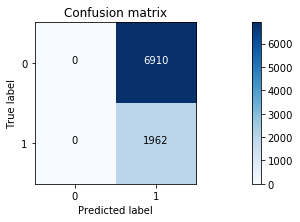

f1 = 0.362
acc = 0.221
prec = 0.221
rec = 1.000


In [28]:
clf = DummyClassifier(random_state=r)
_ = train_cv_test_score_target_pred(clf, 'baseline')

# NO PROBA - Linear Support Vector Classifier

In [29]:
if False: # Does not predict_proba
    clf = LinearSVC(penalty='l2',
                loss='squared_hinge',
                dual=False,
                tol=1e-4,
                C=0.01,
                fit_intercept=True,
                intercept_scaling=1.0,
                class_weight='balanced',
                verbose=0,
                random_state=r,
                max_iter=1000
               )
    _ = train_cv_test_score_target_pred(clf, 'ale_kmeans')

# TOO SLOW - Support Vector Classifier

In [30]:
if False:
    clf = SVC(random_state=r, C=1)
    _ = train_cv_test_score_target_pred(clf, 'ale_kmeans')

# Decision Tree Classifier
- ale_kmeans Threshold = 0.25 f1_cv = 0.524 ± 0.024 f1 = 0.525

Evaluating on ale_kmeans dataset


C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


==== Cross validation report ====
Threshold = 0.25
f1_cv = 0.524 ± 0.024
acc_cv = 0.771 ± 0.015
prec_cv = 0.487 ± 0.029
rec_cv = 0.570 ± 0.053
======= Test report =============
Threshold = 0.25


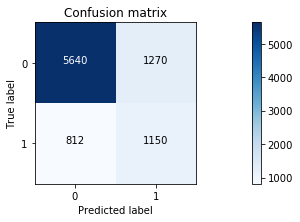

f1 = 0.525
acc = 0.765
prec = 0.475
rec = 0.586


In [31]:
clf = DecisionTreeClassifier(random_state=r, max_depth=4)
_ = train_cv_test_score_target_pred(clf, 'ale_kmeans')

# Gaussian Naive Bayes
baseline Threshold = 0.48 f1_cv = 0.522 ± 0.016 f1 = 0.528

Evaluating on baseline dataset
==== Cross validation report ====
Threshold = 0.48
f1_cv = 0.522 ± 0.016
acc_cv = 0.764 ± 0.010
prec_cv = 0.472 ± 0.018
rec_cv = 0.583 ± 0.024
======= Test report =============
Threshold = 0.48


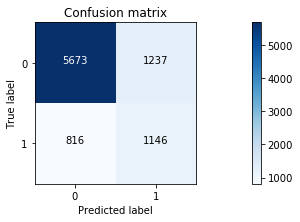

f1 = 0.528
acc = 0.769
prec = 0.481
rec = 0.584


In [32]:
# No random_state
# The priors are set based on class distribution in the dataset
# No CV needed
clf = GaussianNB()
_ = train_cv_test_score_target_pred(clf, 'baseline')

# Random Forest Classifier
- 1000 ale_kmeans Threshold = 0.24 f1_cv = 0.545 ± 0.022 f1 = 0.547

Evaluating on ale_kmeans dataset
Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10


/Users/mattiacrippa/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mattiacrippa/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


==== Cross validation report ====
Threshold = 0.24
f1_cv = 0.545 ± 0.022
acc_cv = 0.787 ± 0.012
prec_cv = 0.517 ± 0.024
rec_cv = 0.577 ± 0.026
======= Test report =============
Threshold = 0.24


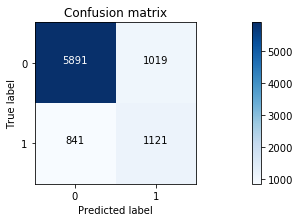

f1 = 0.547
acc = 0.790
prec = 0.524
rec = 0.571


In [31]:
clf = RandomForestClassifier(random_state=r,
                             criterion='gini',
                             max_depth=4,
                             n_jobs=-1,
                             n_estimators=1000,
                             # 2000 ale_kmeans Threshold = 0.25 f1_cv = 0.546 ± 0.024 prec_cv = 0.534 ± 0.025 f1 = 0.546
                             max_features=4,
                             oob_score=True,
                             min_samples_leaf=20,
                             max_leaf_nodes=20
                            )
_ = train_cv_test_score_target_pred(clf, 'ale_kmeans')

Feature ranking:
1. feature PAY_DEC (0.289900)
2. feature PAY_NOV (0.154848)
3. feature CLUSTER_2 (0.133644)
4. feature PAY_OCT (0.081714)
5. feature PAY_SEP (0.061563)
6. feature PAY_AUG (0.052786)
7. feature PAY_JUL (0.047200)
8. feature PAY_AMT_DEC (0.032433)
9. feature LIMIT_BAL (0.020574)
10. feature PAY_AMT_NOV (0.014957)
11. feature PAY_AMT_OCT (0.014371)
12. feature BILL_AMT_DEC (0.011375)
13. feature PAY_AMT_SEP (0.011239)
14. feature CLUSTER_3 (0.009133)
15. feature BILL_AMT_NOV (0.009087)
16. feature PAY_AMT_AUG (0.008556)
17. feature CLUSTER_0 (0.008256)
18. feature BILL_AMT_AUG (0.007146)
19. feature BILL_AMT_OCT (0.007047)
20. feature PAY_AMT_JUL (0.006784)
21. feature BILL_AMT_SEP (0.006446)
22. feature BILL_AMT_JUL (0.004544)
23. feature AGE (0.002620)
24. feature CLUSTER_1 (0.001898)
25. feature EDUCATION (0.000783)
26. feature MARRIAGE (0.000454)
27. feature M (0.000342)
28. feature F (0.000302)


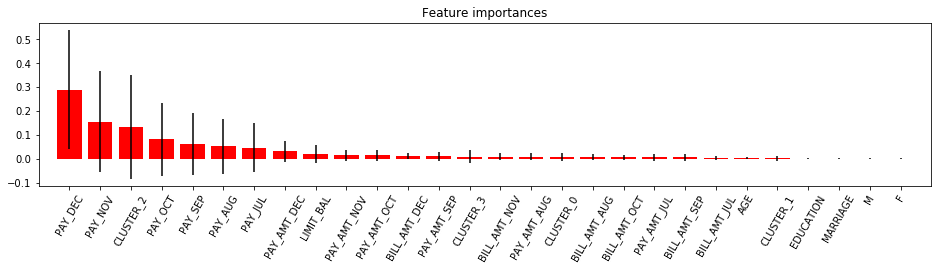

In [103]:
X, y, _, _, _ = retrieve_dataset('ale_kmeans')
forest = clf
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
l_cols = list(X.columns)
labels = [X.columns[i] for i in indices]

# Print the feature ranking
print("Feature ranking:")
for f in np.arange(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, labels[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(np.arange(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(np.arange(X.shape[1]), labels, rotation=60)
plt.xlim([-1, X.shape[1]])
plt.show()

# K Neighbors Classifier
- ale_kmeans Threshold = 0.3 f1_cv = 0.531 ± 0.021 f1 = 0.526

Evaluating on ale_kmeans dataset


C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


==== Cross validation report ====
Threshold = 0.3
f1_cv = 0.531 ± 0.021
acc_cv = 0.790 ± 0.010
prec_cv = 0.526 ± 0.023
rec_cv = 0.536 ± 0.025
======= Test report =============
Threshold = 0.3


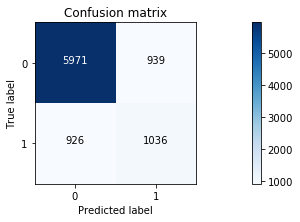

f1 = 0.526
acc = 0.790
prec = 0.525
rec = 0.528


In [35]:
clf = KNeighborsClassifier(n_neighbors=40,
                           weights='distance',
                           algorithm='auto',
                           leaf_size=30,
                           p=2,
                           metric='minkowski',
                           metric_params=None,
                           n_jobs=-1
                          )
_ = train_cv_test_score_target_pred(clf, 'ale_kmeans')

# Multi Layer Perceptron Classifier
- ale_kmeans Threshold = 0.29 f1_cv = 0.541 ± 0.022 f1 = 0.542

Evaluating on ale_kmeans dataset


C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


==== Cross validation report ====
Threshold = 0.29
f1_cv = 0.541 ± 0.022
acc_cv = 0.797 ± 0.012
prec_cv = 0.542 ± 0.027
rec_cv = 0.540 ± 0.024
======= Test report =============
Threshold = 0.29


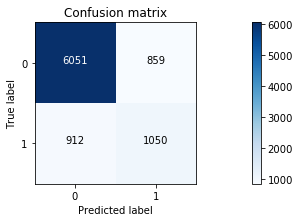

f1 = 0.542
acc = 0.800
prec = 0.550
rec = 0.535


In [75]:
clf = MLPClassifier(hidden_layer_sizes=(14),
                    activation='logistic',
                    alpha=0.001,
                    random_state=r,
                   )
_ = train_cv_test_score_target_pred(clf, 'ale_kmeans')

# Logistic Regression
- ale_kmeans Threshold = 0.25 f1_cv = 0.525 ± 0.025 f1 = 0.519

Evaluating on ale_kmeans dataset


C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


==== Cross validation report ====
Threshold = 0.25
f1_cv = 0.525 ± 0.025
acc_cv = 0.780 ± 0.013
prec_cv = 0.502 ± 0.027
rec_cv = 0.550 ± 0.024
======= Test report =============
Threshold = 0.25


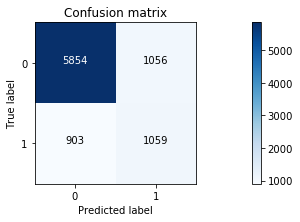

f1 = 0.519
acc = 0.779
prec = 0.501
rec = 0.540


In [227]:
clf = LogisticRegression(penalty='l1', C=1, fit_intercept=True, random_state=r, n_jobs=-1)
_ = train_cv_test_score_target_pred(clf, 'ale_kmeans')

[[-0.18  0.04  0.14  0.44  0.08 -0.02  0.04  0.05  0.08 -0.27  0.07  0.31
   0.18 -0.23  0.12 -0.12 -0.17 -0.11 -0.05 -0.08 -0.    0.16  0.25  0.09
  -0.47  0.    0.27 -0.55]]


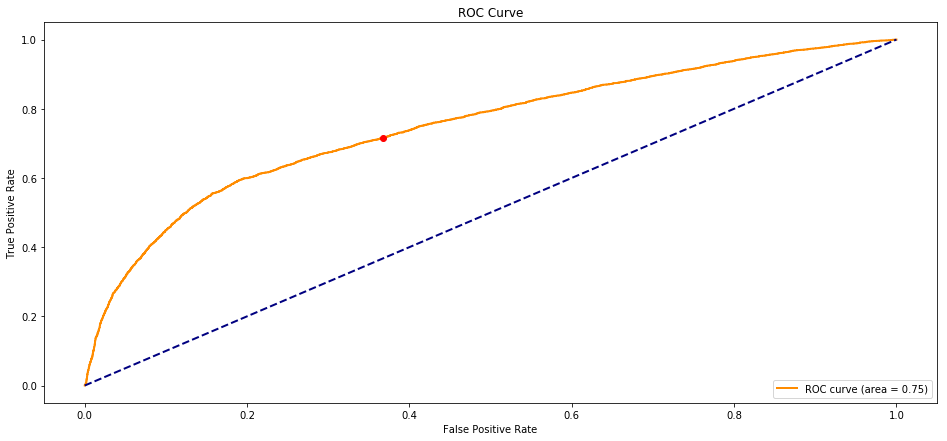

In [228]:
X, y, _, _, _ = retrieve_dataset('ale_kmeans')
clf.fit(X, y)
print(clf.coef_)
plot_roc_curve(clf, 0.25, X, y)

# XGBClassifier
- ale_kmeans Threshold = 0.27 f1_cv = 0.547 ± 0.023 f1 = 0.547

Evaluating on ale_kmeans dataset


C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


==== Cross validation report ====
Threshold = 0.27
f1_cv = 0.547 ± 0.023
acc_cv = 0.796 ± 0.010
prec_cv = 0.538 ± 0.023
rec_cv = 0.557 ± 0.027
======= Test report =============
Threshold = 0.27


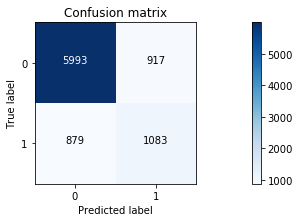

f1 = 0.547
acc = 0.798
prec = 0.541
rec = 0.552


In [73]:
clf = XGBClassifier(seed=r, reg_lambda=0.01)
_ = train_cv_test_score_target_pred(clf, 'ale_kmeans')

Feature ranking:
1. feature BILL_AMT_DEC (0.138554)
2. feature PAY_DEC (0.084337)
3. feature BILL_AMT_OCT (0.073795)
4. feature PAY_AMT_DEC (0.072289)
5. feature LIMIT_BAL (0.066265)
6. feature PAY_AMT_NOV (0.060241)
7. feature PAY_AMT_JUL (0.058735)
8. feature PAY_AMT_SEP (0.046687)
9. feature PAY_AMT_OCT (0.046687)
10. feature PAY_JUL (0.043675)
11. feature PAY_AMT_AUG (0.043675)
12. feature BILL_AMT_AUG (0.031627)
13. feature AGE (0.027108)
14. feature PAY_SEP (0.027108)
15. feature EDUCATION (0.025602)
16. feature BILL_AMT_SEP (0.022590)
17. feature BILL_AMT_NOV (0.022590)
18. feature PAY_NOV (0.022590)
19. feature BILL_AMT_JUL (0.019578)
20. feature PAY_OCT (0.016566)
21. feature PAY_AUG (0.015060)
22. feature MARRIAGE (0.013554)
23. feature CLUSTER_2 (0.009036)
24. feature M (0.007530)
25. feature CLUSTER_0 (0.004518)
26. feature F (0.000000)
27. feature CLUSTER_1 (0.000000)
28. feature CLUSTER_3 (0.000000)


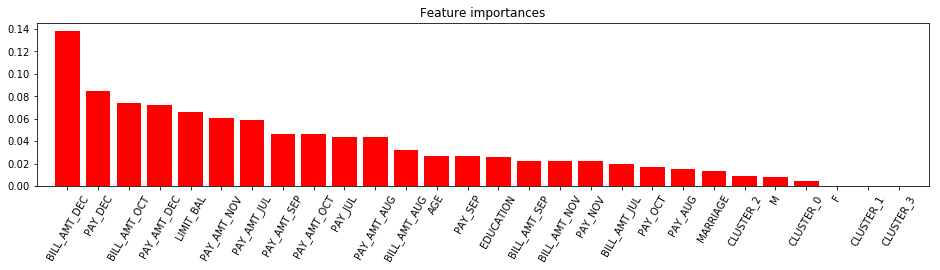

In [74]:
X, y, _, _, _ = retrieve_dataset('ale_kmeans')
forest = clf
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
l_cols = list(X.columns)
labels = [X.columns[i] for i in indices]

# Print the feature ranking
print("Feature ranking:")
for f in np.arange(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, labels[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(np.arange(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(np.arange(X.shape[1]), labels, rotation=60)
plt.xlim([-1, X.shape[1]])
plt.show()

# MEMORY ERROR, Gaussian Process Classifier

In [171]:
if False:
    clf = GaussianProcessClassifier(kernel=None,
                                optimizer='fmin_l_bfgs_b',
                                n_restarts_optimizer=0, 
                                max_iter_predict=100,
                                warm_start=False,
                                copy_X_train=True,
                                random_state=r,
                                #multi_class='one_vs_rest',
                                n_jobs=-1)
    _ = train_cv_test_score_target_pred(clf, 'ale_kmeans')

# Linear Discriminant Analysis
ale_kmeans Threshold = 0.21 f1_cv = 0.524 ± 0.026 f1 = 0.516

Evaluating on ale_kmeans dataset


C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


==== Cross validation report ====
Threshold = 0.21
f1_cv = 0.524 ± 0.026
acc_cv = 0.781 ± 0.014
prec_cv = 0.504 ± 0.028
rec_cv = 0.546 ± 0.028
======= Test report =============
Threshold = 0.21


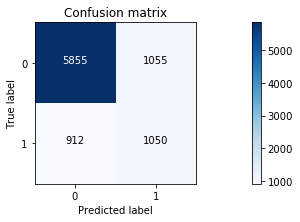

f1 = 0.516
acc = 0.778
prec = 0.499
rec = 0.535


In [231]:
clf = LinearDiscriminantAnalysis(solver='svd', shrinkage=None, n_components=None, store_covariance=False, tol=0.0001)
_ = train_cv_test_score_target_pred(clf, 'ale_kmeans')

# Quadratic Discriminant Analysis
ale_kmeans Threshold = 0.3 f1_cv = 0.530 ± 0.022 f1 = 0.524

Evaluating on ale_kmeans dataset


C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


==== Cross validation report ====
Threshold = 0.3
f1_cv = 0.530 ± 0.022
acc_cv = 0.768 ± 0.013
prec_cv = 0.481 ± 0.024
rec_cv = 0.590 ± 0.025
======= Test report =============
Threshold = 0.3


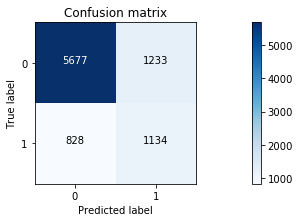

f1 = 0.524
acc = 0.768
prec = 0.479
rec = 0.578


In [232]:
clf = QuadraticDiscriminantAnalysis(reg_param=0.1, store_covariances=False, tol=0.0001)
_ = train_cv_test_score_target_pred(clf, 'ale_kmeans')

# NON FUNZIONA PER NIENTE - Stacking Classifier

In [245]:
X, y, _, _, _ = retrieve_dataset('ale_kmeans')

from mlxtend.classifier import StackingClassifier

clf1 = XGBClassifier(seed=r, scale_pos_weight=3)
clf2 = RandomForestClassifier(random_state=r, max_depth=4, n_estimators=300, max_features=3, class_weight='balanced')
clf3 = DecisionTreeClassifier(max_depth=4, random_state=r, class_weight='balanced')
lr = LogisticRegression(random_state=r, class_weight='balanced')
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3],
                          use_probas=True,
                          average_probas=False,
                          meta_classifier=lr)

print('10-fold stratified cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['XGB', 
                       'Random Forest', 
                       'Decision Tree',
                       'StackingClassifier']):

    scores = cross_val_score(clf, X, y, cv=cv, scoring='f1')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

10-fold stratified cross validation:

Accuracy: 0.54 (+/- 0.02) [XGB]
Accuracy: 0.54 (+/- 0.03) [Random Forest]
Accuracy: 0.52 (+/- 0.02) [Decision Tree]
Accuracy: 0.53 (+/- 0.02) [StackingClassifier]


# Voting Classifier Ensemble

Evaluating on ale_kmeans dataset
Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10


/Users/mattiacrippa/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mattiacrippa/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


==== Cross validation report ====
Threshold = 0.24
f1_cv = 0.548 ± 0.022
acc_cv = 0.784 ± 0.012
prec_cv = 0.511 ± 0.024
rec_cv = 0.592 ± 0.027
======= Test report =============
Threshold = 0.24


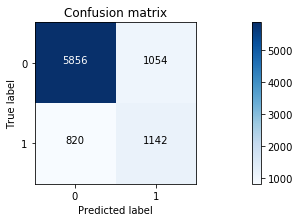

f1 = 0.549
acc = 0.789
prec = 0.520
rec = 0.582


In [28]:
from sklearn.ensemble import VotingClassifier

X, y, _, _, _ = retrieve_dataset('ale_kmeans')

rf = RandomForestClassifier(random_state=r,
                             criterion='gini',
                             max_depth=4,
                             n_jobs=-1,
                             n_estimators=1000,
                             max_features=4,
                             oob_score=True,
                             min_samples_leaf=20,
                             max_leaf_nodes=20
                            )
xgb = XGBClassifier(seed=r, reg_lambda=0.01)
mlp = MLPClassifier(hidden_layer_sizes=(14),
                    activation='logistic',
                    alpha=0.001,
                    random_state=r,
                   )

eclf = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb), ('mlp', mlp)], 
                        voting='soft', 
                        n_jobs=-1, 
                        weights=[0.4,0.4,0.2])

target_pred = train_cv_test_score_target_pred(eclf, 'ale_kmeans')
target_pred.to_csv('test.csv', header=['DEFAULT PAYMENT JAN'])
#target_pred.to_csv('test.csv', index=False)